In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scipy
import sys
from skimage import measure
import cv2
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

import warnings 
warnings.filterwarnings('ignore') 

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'


In [2]:

sample_id = 'V1_Human_Lymph_Node'

adata = sc.datasets.visium_sge(sample_id="V1_Human_Lymph_Node", include_hires_tiff=True)

patch_size = (36,36) 

In [3]:
adata.var_names_make_unique()

In [4]:
# adata = adata[adata.obs['pathology'] != "Artefact"]
# adata = adata[adata.obs['pathology'] != "Uncertain"]
# adata = adata[adata.obs['pathology'] != np.nan]
sc.pp.filter_genes(adata, min_cells=5)
sc.pp.filter_cells(adata, min_counts=5000)

In [6]:
# Convert images
img_hires = adata.uns['spatial'][sample_id]['images']['hires']
print(img_hires.shape)
# img_lowres = adata.uns['spatial'][sample_id]['images']['lowres']
scale_factor = adata.uns['spatial'][sample_id]['scalefactors']['tissue_hires_scalef']

# gray_image = cv2.cvtColor((img_hires * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

(2000, 1921, 3)


In [7]:
spatial_coords = adata.obsm['spatial'] * scale_factor

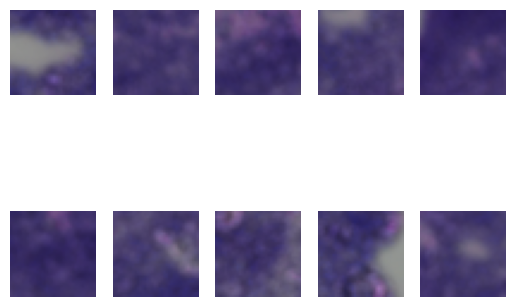

3991


In [8]:
# Extract patches from the tissue region and assign the nearest spatial spot
patches = []
patch_spot_mapping = []
ii=0
for i, spot in enumerate(spatial_coords):
    spot_x, spot_y = spot 
    spot_x = int(spot_x)
    spot_y = int(spot_y)
    
    # and spot_x +patch_size[0]< img_hires.shape[0] and spot_y \ +patch_size[1]< img_hires.shape[1] and \
    #spot_x-x_min<x+w and spot_y-y_min<y+h:
    patch = img_hires[spot_y:spot_y + patch_size[1], spot_x:spot_x + patch_size[0], :]
    
    if patch.shape[0] < patch_size[0] or patch.shape[1] < patch_size[1]:
        patch = cv2.copyMakeBorder(patch, 0, patch_size[0] - patch.shape[0], 0, patch_size[1] - patch.shape[1], cv2.BORDER_CONSTANT, value=0)
    patches.append(patch)
    ii+=1
    patch_spot_mapping.append({
        'patch': patches[len(patches)-1],
        'spot': adata.obs_names[i]
    })
    

for i, entry in enumerate(patch_spot_mapping[:10]):  # Display first 10 patches
    plt.subplot(2, 5, i + 1)
    plt.imshow(entry['patch'])
    #plt.title(f'sp: {entry["spot"]}')
    plt.axis('off')
plt.show()

unique_spots = set()
unique_patch_spot_mapping = []


print(ii)

In [10]:
# Get the list of spot names from patch_spot_mapping
mapped_spot_names = [entry['spot'] for entry in patch_spot_mapping]
# Find the intersection of spot names between mapped_spot_names and adata.obs_names
common_spots = list(set(mapped_spot_names) & set(adata.obs_names))
# Filter patch_spot_mapping to keep only the common spots
filtered_patch_spot_mapping = [entry for entry in patch_spot_mapping if entry['spot'] in common_spots]
unique_spots = set()

# Filter the patch_spot_mapping to ensure unique spot entries
unique_filtered_patch_spot_mapping = []
for entry in filtered_patch_spot_mapping:
    spot = entry['spot']
    if spot not in unique_spots:
        unique_filtered_patch_spot_mapping.append(entry)
        unique_spots.add(spot)  # Add the spot to the set to track uniqueness


# Separate the spots and patches into two lists
spots = [entry['spot'] for entry in unique_filtered_patch_spot_mapping]  # List of spot names
patches = [entry['patch'] for entry in unique_filtered_patch_spot_mapping]  # List of corresponding patches

patches=np.array(patches)
# Only keep the spots inside the tissue
adata_filtered = adata[adata.obs_names.isin(common_spots)]

output_dir = './results'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

adata_filtered.write("./results/"+sample_id+f"{patch_size[0]}*{patch_size[0]}.h5ad")
np.save("./results/"+sample_id+f"_{patch_size[0]}*{patch_size[0]}_patches.npy",patches)
np.save("./results/"+sample_id+f"_{patch_size[0]}*{patch_size[0]}_spots.npy",spots)

In [11]:
adata_filtered

AnnData object with n_obs × n_vars = 3991 × 21261
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial'

In [12]:
adata_filtered=sc.read("./results/"+sample_id+f"{patch_size[0]}*{patch_size[0]}.h5ad")

img_data=np.load("./results/"+sample_id+f"_{patch_size[0]}*{patch_size[0]}_patches.npy")
barcodes=np.load("./results/"+sample_id+f"_{patch_size[0]}*{patch_size[0]}_spots.npy")

In [13]:
len(img_data)

3991

In [14]:
adata_filtered

AnnData object with n_obs × n_vars = 3991 × 21261
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial'

In [15]:
import torch
device = torch.device("cuda")
# Convert to PyTorch tensor and change the order of dimensions to (N, C, H, W)
img_tensor = torch.tensor(img_data, dtype=torch.float32).permute(0, 3, 1, 2)

# Normalize the images between [0, 1] if not already done
img_tensor = img_tensor / 255.0 if img_tensor.max() > 1.0 else img_tensor

print(img_tensor.shape)  

torch.Size([3991, 3, 36, 36])


In [16]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms


import cv2
import numpy as np

def histogram_equalization(img):
    if img.dtype != np.uint8:
        img = (img * 255).astype(np.uint8)

    img_eq = img
    
    # if len(img.shape) == 3 and img.shape[2] == 3:
    #     img_y_cr_cb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        
    #     # EH
    #     img_y_cr_cb[:, :, 0] = cv2.equalizeHist(img_y_cr_cb[:, :, 0])

    #     img_eq = cv2.cvtColor(img_y_cr_cb, cv2.COLOR_YCrCb2BGR)
    # elif len(img.shape) == 2:
    #     img_eq = cv2.equalizeHist(img)
    # else:
    #     raise ValueError("Unsupported image shape for histogram equalization.")
    
    return img_eq


class HistogramEqualizationDataset(Dataset):
    def __init__(self, img_data, transform=None):
        self.img_data = img_data
        self.transform = transform

    def __len__(self):
        return self.img_data.shape[0]

    def __getitem__(self, idx):
        img = self.img_data[idx]
        img = histogram_equalization(img)
        if self.transform:
            img = self.transform(img)
        return img

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = HistogramEqualizationDataset(img_data, transform=transform)
# Create a DataLoader
batch_size = 8
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)


## BiGAN
Training may take hours without gpu

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.models as models
from torch.nn.utils import spectral_norm

# Weight initialization function
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('Linear') != -1:
        nn.init.kaiming_normal_(m.weight, a=0.2)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif classname.find('BatchNorm') != -1:
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

# Encoder (E)
class Encoder(nn.Module):
    def __init__(self, latent_dim=128):
        super(Encoder, self).__init__()
        self.model = nn.Sequential(
            # Input: 3 x 26 x 26
            nn.Conv2d(3, 32, 4, 2, 1),    # Output: 32 x 13 x 13
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, 4, 2, 1),   # Output: 64 x 6 x 6
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),  # Output: 128 x 3 x 3
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(128 * 3 * 3, latent_dim)
        )

    def forward(self, x):
        return self.model(x)

# Generator (G)
class Generator(nn.Module):
    def __init__(self, latent_dim=128):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128 * 3 * 3),
            nn.LeakyReLU(0.2),
            nn.Unflatten(1, (128, 3, 3)),
            nn.BatchNorm2d(128),
            # First deconvolution
            nn.ConvTranspose2d(128, 64, 4, 2, 1),  # Output: 64 x 6 x 6
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            # Second deconvolution
            nn.ConvTranspose2d(64, 32, 4, 2, 1),   # Output: 32 x 12 x 12
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            # Third deconvolution
            nn.ConvTranspose2d(32, 16, 4, 2, 1),   # Output: 16 x 24 x 24
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            nn.Upsample(size=(36, 36), mode='bilinear', align_corners=False),
            nn.Conv2d(16, 3, 3, 1, 1),             # Output: 3 x 36 x 36
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

# Discriminator (D)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            spectral_norm(nn.Conv2d(3, 32, 4, 2, 1)),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            
            spectral_norm(nn.Conv2d(32, 64, 4, 2, 1)),     # Output: 64 x 9 x 9
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            
            spectral_norm(nn.Conv2d(64, 128, 4, 2, 1)),    # Output: 128 x 4 x 4
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            spectral_norm(nn.Conv2d(128, 256, 4, 1, 0)),   # Output: 256 x 1 x 1
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Flatten(),
            nn.Linear(256, 1)            
        )
    
    def forward(self, x):
        validity = self.net(x)
        return validity
        
class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        self.vgg = models.vgg16(pretrained=True).features[:16].eval()
        for param in self.vgg.parameters():
            param.requires_grad = False

    def forward(self, x, y):
        return nn.functional.l1_loss(self.vgg(x), self.vgg(y))

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize models
latent_dim = 128
encoder = Encoder(latent_dim).to(device)
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)
perceptual_loss = PerceptualLoss().to(device)

# Apply weight initialization
encoder.apply(weights_init)
generator.apply(weights_init)
discriminator.apply(weights_init)



Discriminator(
  (net): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=256, out_features=1, bias=True)
  

In [18]:
import torchvision.utils as vutils

adversarial_loss = nn.BCEWithLogitsLoss()
reconstruction_loss_function = nn.L1Loss()
lambda_recon = 20  # Recon_loss_weight

optimizer_D = optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.8))
optimizer_G = optim.Adam(generator.parameters(), lr=1e-3, betas=(0.5, 0.85))
optimizer_E = optim.Adam(encoder.parameters(), lr=1e-3, betas=(0.5, 0.85))

num_epochs = 50
real_label = 0.9
fake_label = 0.1

os.makedirs('t_r/real_fake', exist_ok=True)

for epoch in range(num_epochs):
    encoder.train()
    generator.train()
    discriminator.train()
    for batch_idx, batch in enumerate(data_loader):
        batch = batch.to(device)
        current_batch_size = batch.size(0)

        label_real = torch.full(
            (current_batch_size, 1), real_label, device=device, dtype=torch.float
        )
        label_fake = torch.full(
            (current_batch_size, 1), fake_label, device=device, dtype=torch.float
        )

        center_crop = batch[:, :, 5:31, 5:31]  #36-26

        optimizer_D.zero_grad()

        # Real
        validity_real = discriminator(batch)
        loss_D_real = adversarial_loss(validity_real, label_real)

        # Generate
        with torch.no_grad():
            z_fake = encoder(center_crop)
            x_fake = generator(z_fake)
        validity_fake = discriminator(x_fake.detach())
        loss_D_fake = adversarial_loss(validity_fake, label_fake)

        # Loss for D
        loss_D = (loss_D_real + loss_D_fake) / 2
        loss_D.backward()

        torch.nn.utils.clip_grad_norm_(discriminator.parameters(), max_norm=1.0)

        optimizer_D.step()

        # Train E and G
        optimizer_E.zero_grad()
        optimizer_G.zero_grad()

        z_fake = encoder(center_crop)
        x_fake = generator(z_fake)
        validity = discriminator(x_fake)
        adversarial_loss_value = adversarial_loss(validity, label_real)

        # recon_loss
        reconstruction_loss_value = reconstruction_loss_function(x_fake, batch)

        # total loss
        loss_GE = adversarial_loss_value + lambda_recon * reconstruction_loss_value + perceptual_loss(x_fake, batch)

        loss_GE.backward()

        torch.nn.utils.clip_grad_norm_(generator.parameters(), max_norm=3)
        torch.nn.utils.clip_grad_norm_(encoder.parameters(), max_norm=3)

        optimizer_E.step()
        optimizer_G.step()

        if batch_idx % 100 == 0:
            with torch.no_grad():
                batch = batch.to(device)

                # emb
                z_fake = encoder(center_crop).detach()
                # img
                fake_images = generator(z_fake).cpu()
                real_images = batch.cpu()

                # create grid
                real_grid = vutils.make_grid(real_images, nrow=8, normalize=True, padding=2)
                fake_grid = vutils.make_grid(fake_images, nrow=8, normalize=True, padding=2)

                # cat
                combined_grid = torch.cat((real_grid, fake_grid), dim=1)  # dim=1 

                # save
                vutils.save_image(combined_grid, f'./t_r/real_fake/real_fake_epoch_{epoch+1}_batch_{batch_idx}.png')

    
                print(
                f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(data_loader)}], '
                f'Loss D: {loss_D.item():.4f}, Loss GE: {loss_GE.item():.4f}'
            )
            with torch.no_grad():
                print(
                    f'Validity Real Mean: {validity_real.mean().item():.4f}, '
                    f'Std: {validity_real.std().item():.4f}'
                )
                print(
                    f'Validity Fake Mean: {validity_fake.mean().item():.4f}, '
                    f'Std: {validity_fake.std().item():.4f}'
                )
                print(
                    f'Validity GE Mean: {validity.mean().item():.4f}, '
                    f'Std: {validity.std().item():.4f}'
                )
                print(
                    f'Reconstruction Loss: {reconstruction_loss_value.item():.4f}'
                )

Epoch [1/50], Batch [0/498], Loss D: 0.7427, Loss GE: 11.6014
Validity Real Mean: 0.1542, Std: 0.7853
Validity Fake Mean: 0.0886, Std: 0.7422
Validity GE Mean: -0.1347, Std: 0.5109
Reconstruction Loss: 0.4788
Epoch [1/50], Batch [100/498], Loss D: 0.7154, Loss GE: 2.9247
Validity Real Mean: -0.0078, Std: 0.4861
Validity Fake Mean: -0.0228, Std: 0.4844
Validity GE Mean: -0.1092, Std: 0.3109
Reconstruction Loss: 0.0802
Epoch [1/50], Batch [200/498], Loss D: 0.6895, Loss GE: 2.6198
Validity Real Mean: 0.0588, Std: 0.2786
Validity Fake Mean: -0.0012, Std: 0.2671
Validity GE Mean: -0.0706, Std: 0.3402
Reconstruction Loss: 0.0676
Epoch [1/50], Batch [300/498], Loss D: 0.6894, Loss GE: 2.6789
Validity Real Mean: 0.0751, Std: 0.3414
Validity Fake Mean: 0.0045, Std: 0.2623
Validity GE Mean: -0.0317, Std: 0.1210
Reconstruction Loss: 0.0715
Epoch [1/50], Batch [400/498], Loss D: 0.6800, Loss GE: 2.6507
Validity Real Mean: -0.0172, Std: 0.1997
Validity Fake Mean: -0.1072, Std: 0.1869
Validity GE M

In [186]:
# torch.save(encoder.state_dict(), f'./results/{sample_id}_{patch_size[0]}_50l_BIGAN_encoder_new.pth')
# torch.save(generator.state_dict(), f'./results/{sample_id}_{patch_size[0]}_50l_BIGAN_generator.pth')
# torch.save(discriminator.state_dict(), f'./results/{sample_id}_{patch_size[0]}_50l_BIGAN_discriminator.pth')

In [19]:
load_encoder = encoder
#load_encoder = Encoder(latent_dim).to(device)

In [20]:
# path = './results/'+sample_id+f"_{patch_size[0]}_50l_BIGAN_encoder_new.pth"
# #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# load_encoder.load_state_dict(torch.load(path,map_location=torch.device('cpu')))

In [21]:
test_dataset = HistogramEqualizationDataset(img_data, transform=transform)

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

load_encoder.eval()
generator.eval()
discriminator.eval()

results = []
os.makedirs('t_r/test_results', exist_ok=True)

with torch.no_grad():
    for batch_idx, batch in enumerate(test_loader):
        batch = batch.to(device)
        current_batch_size = batch.size(0)
        center_crop = batch[:, :, 5:31, 5:31]  # 36-26
        
        z_fake = encoder(center_crop)
        results.append(z_fake.cpu())
        
        x_fake = generator(z_fake).cpu()
        
        # recon_loss, to check the result
        reconstruction_loss = reconstruction_loss_function(x_fake, batch.cpu())
        print(f'Test Batch [{batch_idx}], Reconstruction Loss: {reconstruction_loss.item():.4f}')

        real_images = batch.cpu()
        fake_images = x_fake
  
        real_grid = vutils.make_grid(real_images, nrow=8, normalize=True, padding=2)
        fake_grid = vutils.make_grid(fake_images, nrow=8, normalize=True, padding=2)
        
        combined_grid = torch.cat((real_grid, fake_grid), dim=1)  # dim=1 

        vutils.save_image(combined_grid, f'./t_r/test_results/test_real_fake_batch_{batch_idx}.png')
        
        print(f'Test Batch [{batch_idx}] processed.')

print("Testing Completed.")

Test Batch [0], Reconstruction Loss: 0.0350
Test Batch [0] processed.
Test Batch [1], Reconstruction Loss: 0.0337
Test Batch [1] processed.
Test Batch [2], Reconstruction Loss: 0.0357
Test Batch [2] processed.
Test Batch [3], Reconstruction Loss: 0.0336
Test Batch [3] processed.
Test Batch [4], Reconstruction Loss: 0.0373
Test Batch [4] processed.
Test Batch [5], Reconstruction Loss: 0.0345
Test Batch [5] processed.
Test Batch [6], Reconstruction Loss: 0.0348
Test Batch [6] processed.
Test Batch [7], Reconstruction Loss: 0.0355
Test Batch [7] processed.
Test Batch [8], Reconstruction Loss: 0.0371
Test Batch [8] processed.
Test Batch [9], Reconstruction Loss: 0.0351
Test Batch [9] processed.
Test Batch [10], Reconstruction Loss: 0.0363
Test Batch [10] processed.
Test Batch [11], Reconstruction Loss: 0.0350
Test Batch [11] processed.
Test Batch [12], Reconstruction Loss: 0.0377
Test Batch [12] processed.
Test Batch [13], Reconstruction Loss: 0.0341
Test Batch [13] processed.
Test Batch [

In [22]:
results

[tensor([[  1.9945,   1.4720,  -4.1405,  ...,  -5.1258, -15.2123,  15.5677],
         [-24.7491,  -9.5656,  -6.7698,  ...,  -5.1135,   5.4788,   6.5411],
         [-13.9031,  -0.1143,   3.4008,  ...,  -7.9530,   0.8163,   8.7564],
         ...,
         [-20.4176, -10.6985,   7.1960,  ...,   4.9728,  -7.6538,   5.7112],
         [-12.2823,   1.3056,   7.8954,  ...,   5.1201,  16.5663,  -0.1245],
         [-16.2905,   6.3783,   4.9253,  ...,   8.8324,   3.5894,   6.4671]]),
 tensor([[-12.8803,   4.1849,  -3.2865,  ...,  -6.3885,  -9.0707,   6.9383],
         [-11.1962, -13.3351,   5.3092,  ...,  -5.8649,  -2.2565,  16.9416],
         [-25.3077,  -4.9577,  -8.9385,  ...,  -7.6092,   4.7515,   8.7870],
         ...,
         [ -7.8213,   3.3769,   5.0107,  ...,  17.0046,   5.8317,  -2.1386],
         [-28.5289,   1.2021,   5.9817,  ...,  -3.4862,  -9.1101,   2.7939],
         [-14.5721,  -7.8506,   6.2417,  ...,   3.5037,  -2.8970,  -5.1416]]),
 tensor([[ -3.8360,   6.7276,   1.9845,  ...

In [23]:
del encoder
del generator
del discriminator
encoded_features_bigan = torch.cat(results, dim=0)

In [24]:
np.save("./results/"+sample_id+f"_{patch_size[0]}*{patch_size[0]}_bigan_recon_new_f.npy",encoded_features_bigan)

In [193]:
print("./results/"+sample_id+f"_{patch_size[0]}*{patch_size[0]}_bigan_recon_new_f.npy")
# #Load data
# encoded_features_bigan = np.load('./results/'+sample_id+f"_{patch_size[0]}*{patch_size[0]}_bigan_new_f.npy")

./results/CID44971_36*36_bigan_recon_new_f.npy
